### Bet Sizing from Predicted Probabilities

Let $ p(x) $ denote the probability of label $ x $. To test the null hypothesis $ H_0 : p[x = 1] = \frac{1}{2} $, consider two possible outcomes $ x \in \{-1, 1\} $. The test statistic is calculated as:

$
z = \frac{p[x = 1] - \frac{1}{2}}{\sqrt{p[x=1](1 - p[x=1])}} = \frac{2p[x = 1] - 1}{2\sqrt{p[x=1](1 - p[x=1])}} \sim Z, \quad z \in \left( -\infty, +\infty \right)
$

where $ Z $ follows the standard normal distribution. The bet size is derived as:

$
m = 2Z[z] - 1
$

with $ m \in [-1, 1] $, and $ Z[.] $ representing the cumulative distribution function (CDF) of $ Z $.

---

### When There Are More Than Two Possible Outcomes

If there are more than two possible outcomes, the **One-vs-Rest (OVR)** method is used. Let $ X = \{-1, \dots, 0, \dots, 1\} $ represent the various labels linked to bet sizes, and let $ x \in X $ be the predicted label. In other words, each label is identified by the bet size associated with it.

For each label $ i = 1, \dots, \Vert X \Vert $, estimate $ p_i $, such that:

$
\sum_{i=1}^{\Vert X \Vert} p_i = 1
$

Define $ \tilde{p} = \max_i \{p_i\} $ as the probability of $ x $, and test the null hypothesis:

$
H_0 : \tilde{p} = \frac{1}{\Vert X \Vert}
$

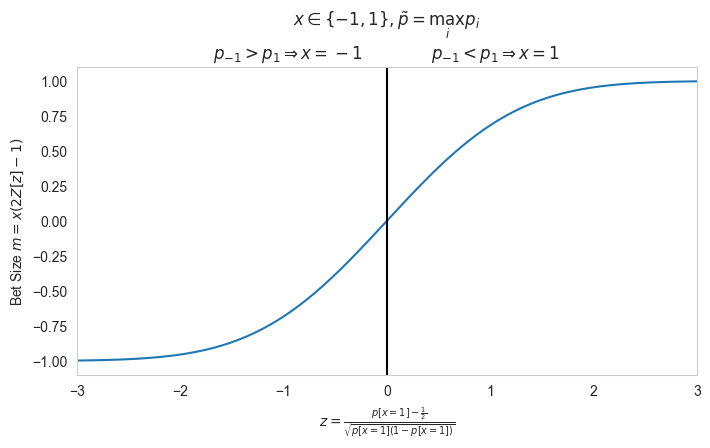

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

p_x1 = np.linspace(0, 1, 500)
eps = 1e-10
p_x1 = np.clip(p_x1, eps, 1 - eps)
z = (2 * p_x1 - 1) / (2 * np.sqrt(p_x1 * (1 - p_x1)))
m = 2 * norm.cdf(z) - 1

plt.figure(figsize=(8, 4))
plt.plot(z, m)
plt.axvline(x=0, color='black', linestyle='-')
plt.xlabel(r'$z = \frac{p[x = 1]  -\frac{1}{2}}{\sqrt{p[x=1](1 - p[x=1])}}$')
plt.xlim([-3, 3])
plt.grid(False)
plt.ylabel(r'Bet Size $m = x(2Z[z] - 1)$')
plt.title(r'$x \in \{-1, 1\}, \tilde{p} = \max_i p_i$' + '\n' + r'$p_{-1} > p_1 \Rightarrow x = -1$' + '\t' + '\t' + r'$p_{-1} < p_1 \Rightarrow x = 1$')

plt.show()

In [2]:
from quant_free.finml.labeling.labeling import *

triple_barrier_event = pd.read_parquet('./research/Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('./research/Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('./research/Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

In [3]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

samples_info_sets = triple_barrier_event.loc[X_train.index].loc[:'2019', 't1']

In [4]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [5]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8641810918774967


In [21]:
from quant_free.finml.bet_sizing.bet_sizing import bet_size_probability

prob_bet = bet_size_probability(
    events = triple_barrier_event.loc['2020':],
    prob = pd.Series(y_prob, index = y_test.index),
    num_classes = 2,
    pred = None, 
    step_size = 0.0, 
    average_active = False, 
    num_threads = 8
)

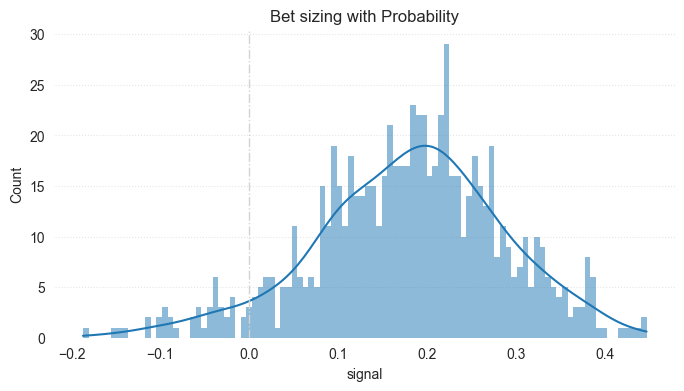

In [27]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(
    prob_bet, 
    ax = ax, 
    edgecolor = 'none', 
    kde = True,
    bins = 100
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet sizing with Probability')
plt.show()

The test statistic is calculated as:

$
z = \frac{\tilde{p} - \frac{1}{\Vert X \Vert}}{\sqrt{\tilde{p}(1-\tilde{p})}} \sim Z
$

From $ z[0, +\infty) $, the bet size is derived as:

$
m = x(2Z[z] - 1) \in [0,1]
$

where $ m \in [-1, 1] $, and $ Z[z] $ adjusts the size of the bet for the prediction $ x $. 

The diagram above illustrates how bet size is expressed as a function of the test statistic. The following code implements the conversion of probabilities into bet sizes. This code handles predictions originating from both standard labeling estimators and meta-labeling estimators.

### Bet Sizing by Expected Sharpe Ratio

Let $ p $ be the probability that an investment opportunity generates a profit $ \pi $, and $ 1 - p $ be the probability that the opportunity results in a loss of $ -\pi $ with symmetric magnitude $ \pi > 0 $. 

The expected profit from the investment opportunity is:

$
\mu = p\pi - (1 - p)(-\pi) = \pi(2p - 1)
$

The expected variance from the investment opportunity is:

$
\sigma^2 = 4\pi^2 p(1-p)
$

The Sharpe Ratio associated with the investment opportunity can then be estimated as:

$
z = \frac{\mu}{\sigma} = \frac{p - \frac{1}{2}}{\sqrt{p(1-p)}}
$

where $ z \in (-\infty, +\infty) $.

Assuming the Sharpe Ratio of the investment opportunity follows a standard Gaussian distribution, the bet size can be derived as:

$
m = 2Z[z] - 1
$

where $ Z[.] $ is the cumulative distribution function (CDF) of the standard Gaussian distribution. Here, $ m \in [-1, 1] $ follows a uniform distribution.

In [8]:
from quant_free.finml.bet_sizing.bet_sizing import get_gaussian_betsize

signals = get_gaussian_betsize(y_prob)

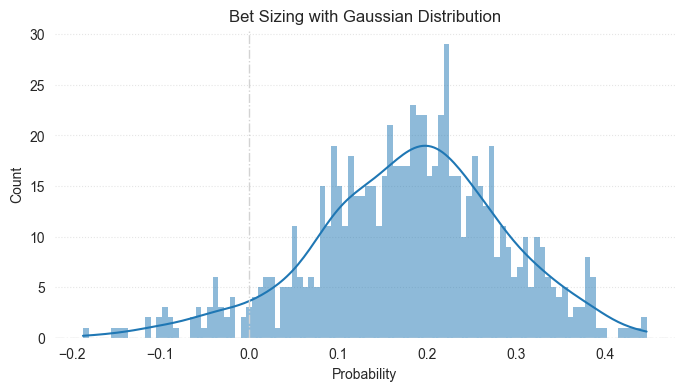

In [15]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(signals, bins = 100, kde = True, edgecolor = 'none', ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet Sizing with Gaussian Distribution')
plt.xlabel('Probability')
plt.show()

### Ensemble Bet Sizing

Consider $ n $ meta-labeling classifiers that make binary predictions about whether an investment opportunity is profitable, i.e., $ y_i = \{0, 1\}, i = 1, \dots, n $. The true probability of profitability is $ p $, and the predictions $ y_i $ are drawn from a Bernoulli distribution. Thus, $ \sum_{i=1}^n y_i \sim B[n,p] $, where $ B[n,p] $ is a binomial distribution with $ n $ trials and success probability $ p $. 

Assuming the predictions are independent and identically distributed, by the De Moivre-Laplace theorem, the distribution of $ \sum_{i=1}^n y_i $ converges to a Gaussian distribution as $ n $ approaches infinity, with mean $ np $ and variance $ np(1-p) $. Therefore:

$
\lim_{n \rightarrow \infty} \frac{1}{n} \sum_{i=1}^n y_i \sim N \left[p, \frac{p(1-p)}{n} \right]
$

This is a special case of the Lindeberg-Levy Central Limit Theorem.

Let $ \hat{p} $ denote the mean prediction of the $ n $ meta-labeling classifiers, i.e., $ \hat{p} = \frac{1}{n} \sum_{i=1}^n y_i $. The standard deviation associated with $ \hat{y} $ is $ \sqrt{\hat{p}(1 - \hat{p}) / n} $. 

Under the null hypothesis $ H_0 : p = \frac{1}{2} $, the test statistic is given by:

$
t = \frac{\hat{p} - \frac{1}{2}}{\sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}}, \quad t \in \left( -\infty, +\infty \right)
$

This follows a t-Student distribution with $ n-1 $ degrees of freedom. The bet size can then be derived as:

$
m = 2t_{n-1}[t] - 1
$

where $ t_{n-1}[.] $ is the cumulative distribution function (CDF) of the t-Student distribution with $ n-1 $ degrees of freedom. Here, $ m \in [-1, 1] $ follows a uniform distribution.

In [17]:
from quant_free.finml.bet_sizing.bet_sizing import get_tstats_betsize

signals = get_tstats_betsize(y_prob, N = 10)

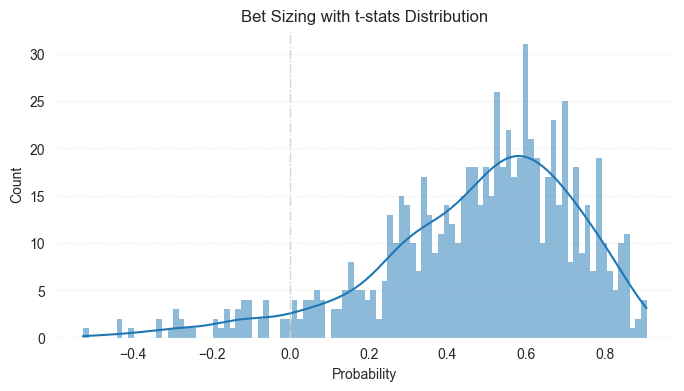

In [18]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(signals, bins = 100, kde = True, edgecolor = 'none', ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.title('Bet Sizing with t-stats Distribution')
plt.xlabel('Probability')
plt.show()